Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST,CIFAR10

selecting device 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Downloading the MNIST dataset and loading

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

testset = MNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 266940469.89it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 33546301.25it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155511139.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17224709.56it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



 Autoencoder models with hidden dimensions of 32 

In [4]:
class Autoencoder32(nn.Module):
    def __init__(self):
        super(Autoencoder32, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

 Autoencoder models with hidden dimensions of 64

In [5]:
class Autoencoder64(nn.Module):
    def __init__(self):
        super(Autoencoder64, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded

Training the model

In [6]:
def train(model, optimizer, criterion, trainloader, testloader, epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(trainloader)
        test_loss = evaluate(model, criterion, testloader)
        print(f"Epoch {epoch+1} -- Train Loss: {train_loss:.4f} -- Test Loss: {test_loss:.4f}")
    

Evaluating the model

In [7]:
def evaluate(model, criterion, dataloader):
    total_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(dataloader.dataset)


Evaluation for 
Autoencoder models with hidden dimensions of 32

In [8]:
criterion = nn.MSELoss()
model32 = Autoencoder32()
model32.to(device)
optimizer32 = optim.Adam(model32.parameters(), lr=0.001)
train(model32, optimizer32, criterion, trainloader, testloader)

Epoch 1 -- Train Loss: 0.6251 -- Test Loss: 0.5697
Epoch 2 -- Train Loss: 0.5535 -- Test Loss: 0.5474
Epoch 3 -- Train Loss: 0.5373 -- Test Loss: 0.5363
Epoch 4 -- Train Loss: 0.5292 -- Test Loss: 0.5310
Epoch 5 -- Train Loss: 0.5254 -- Test Loss: 0.5290
Epoch 6 -- Train Loss: 0.5230 -- Test Loss: 0.5268
Epoch 7 -- Train Loss: 0.5207 -- Test Loss: 0.5251
Epoch 8 -- Train Loss: 0.5191 -- Test Loss: 0.5236
Epoch 9 -- Train Loss: 0.5180 -- Test Loss: 0.5228
Epoch 10 -- Train Loss: 0.5171 -- Test Loss: 0.5221


Evaluation for 
Autoencoder models with hidden dimensions of 64

In [9]:
model64 = Autoencoder64()
model64.to(device)
optimizer64 = optim.Adam(model64.parameters(), lr=0.001)
train(model64, optimizer64, criterion, trainloader, testloader)

Epoch 1 -- Train Loss: 0.6051 -- Test Loss: 0.5465
Epoch 2 -- Train Loss: 0.5294 -- Test Loss: 0.5251
Epoch 3 -- Train Loss: 0.5171 -- Test Loss: 0.5188
Epoch 4 -- Train Loss: 0.5124 -- Test Loss: 0.5159
Epoch 5 -- Train Loss: 0.5095 -- Test Loss: 0.5138
Epoch 6 -- Train Loss: 0.5075 -- Test Loss: 0.5124
Epoch 7 -- Train Loss: 0.5062 -- Test Loss: 0.5115
Epoch 8 -- Train Loss: 0.5051 -- Test Loss: 0.5107
Epoch 9 -- Train Loss: 0.5044 -- Test Loss: 0.5096
Epoch 10 -- Train Loss: 0.5036 -- Test Loss: 0.5091


displaying images

In [10]:
def plot_reconstructions(model, dataloader, n=8):
    images, _ = next(iter(dataloader))
    images = images[:n]
    reconstructions = model(images)
    images = images.detach().numpy()
    reconstructions = reconstructions.detach().numpy()
    fig, axs = plt.subplots(2, n, figsize=(20, 4))
    for i in range(n):
        axs[0][i].imshow(images[i][0], cmap='gray')
        axs[0][i].axis('off')
        axs[1][i].imshow(reconstructions[i][0], cmap='gray')
        axs[1][i].axis('off')
    plt.show()

reconstruction plots for training data of autoencoder 32

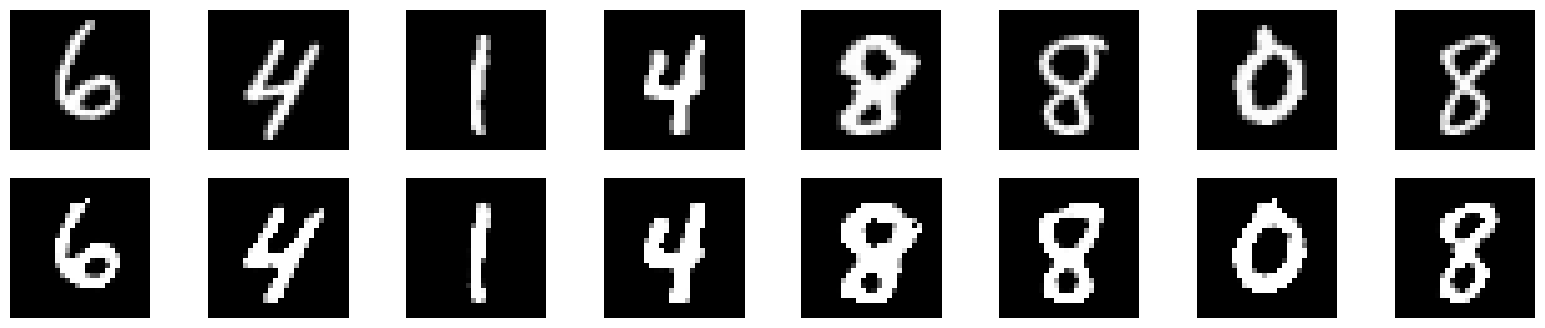

In [11]:
model32 = model32.to('cpu')
plot_reconstructions(model32, trainloader)

reconstruction plots for testing data of autoencoder 32

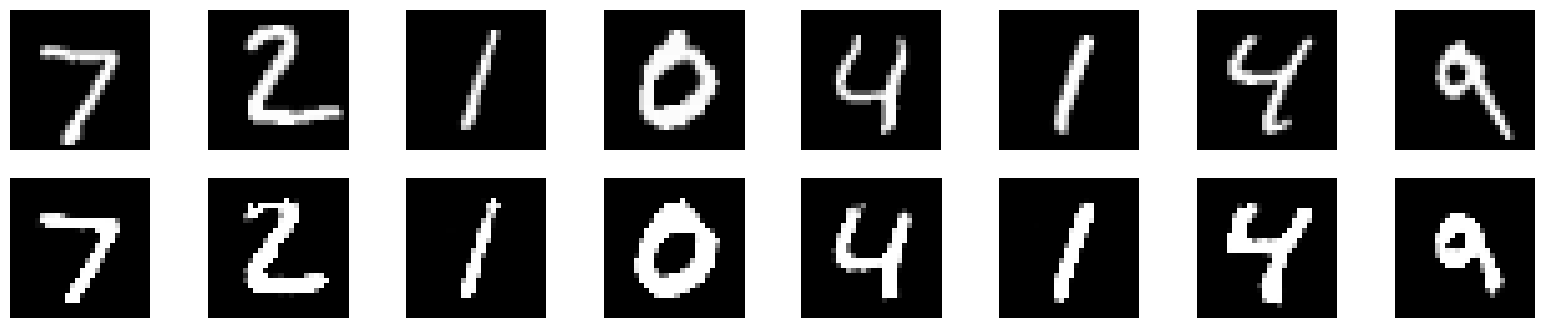

In [12]:
plot_reconstructions(model32, testloader)

reconstruction plots for training data of autoencoder 64

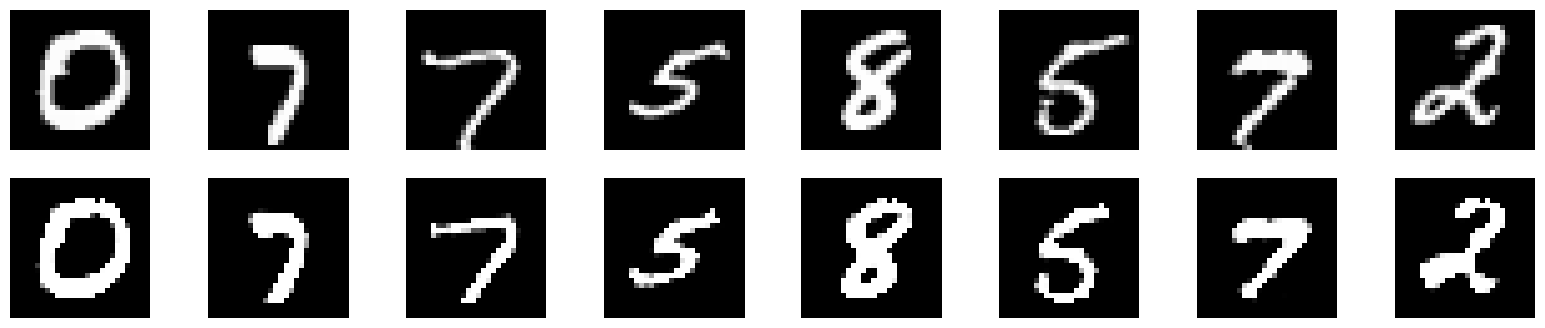

In [13]:
model64 = model64.to('cpu')
plot_reconstructions(model64, trainloader)

reconstruction plots for testing data of autoencoder 64

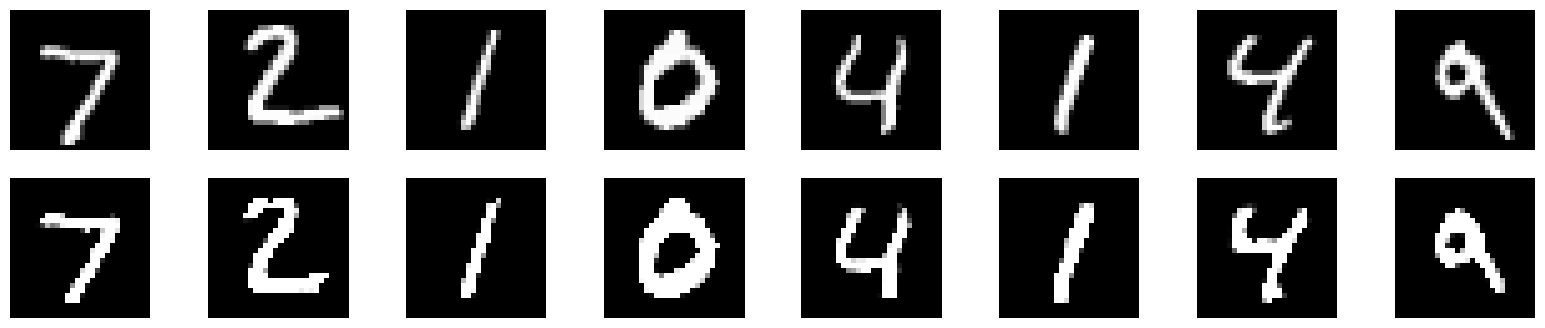

In [14]:
plot_reconstructions(model64, testloader)

Defining interpolate and interpolate in latent space

In [15]:
def interpolate(model, dataloader, n=11):
    images, _ = next(iter(dataloader))
    images = images[:2]
    while images.size(0) < n:
        encoded = model.encoder(images.view(-1, 28*28))
        encoded1, encoded2 = encoded[0], encoded[1]
        t = np.linspace(0, 1, n - images.size(0))
        encoded_t = np.outer(t, encoded1.detach().numpy()) + np.outer(1 - t, encoded2.detach().numpy())
        encoded_t = torch.tensor(encoded_t, dtype=torch.float32)
        decoded_t = model.decoder(encoded_t)
        decoded_t = decoded_t.view(-1, 1, 28, 28)
        images = torch.cat((images, decoded_t), dim=0)
    return images.detach().numpy()

def interpolate_in_latent_space(model, dataloader, n=11):
    images, labels = next(iter(dataloader))
    images = images[:2]
    labels = labels[:2]
    while images.size(0) < n:
        encoded = model.encoder(images.view(-1, 28*28))
        encoded1, encoded2 = encoded[0], encoded[1]
        t = np.linspace(0, 1, n - images.size(0))
        encoded_t = np.outer(t, encoded1.detach().numpy()) + np.outer(1 - t, encoded2.detach().numpy())
        encoded_t = torch.tensor(encoded_t, dtype=torch.float32)
        decoded_t = model.decoder(encoded_t)
        decoded_t = decoded_t.view(-1, 1, 28, 28)
        images = torch.cat((images, decoded_t), dim=0)
        labels = torch.cat((labels, labels[:1]), dim=0)
    encoded_images = model.encoder(images.view(-1, 28*28))
    encoded1, encoded2 = encoded_images[:2]
    t = np.linspace(0, 1, n)
    encoded_t = np.outer(t, encoded1.detach().numpy()) + np.outer(1 - t, encoded2.detach().numpy())
    encoded_t = torch.tensor(encoded_t, dtype=torch.float32)
    decoded_t = model.decoder(encoded_t)
    decoded_t = decoded_t.view(-1, 1, 28, 28)
    return decoded_t.detach().numpy(), labels.detach().numpy()



displaying 5 differnt images that are interpolated

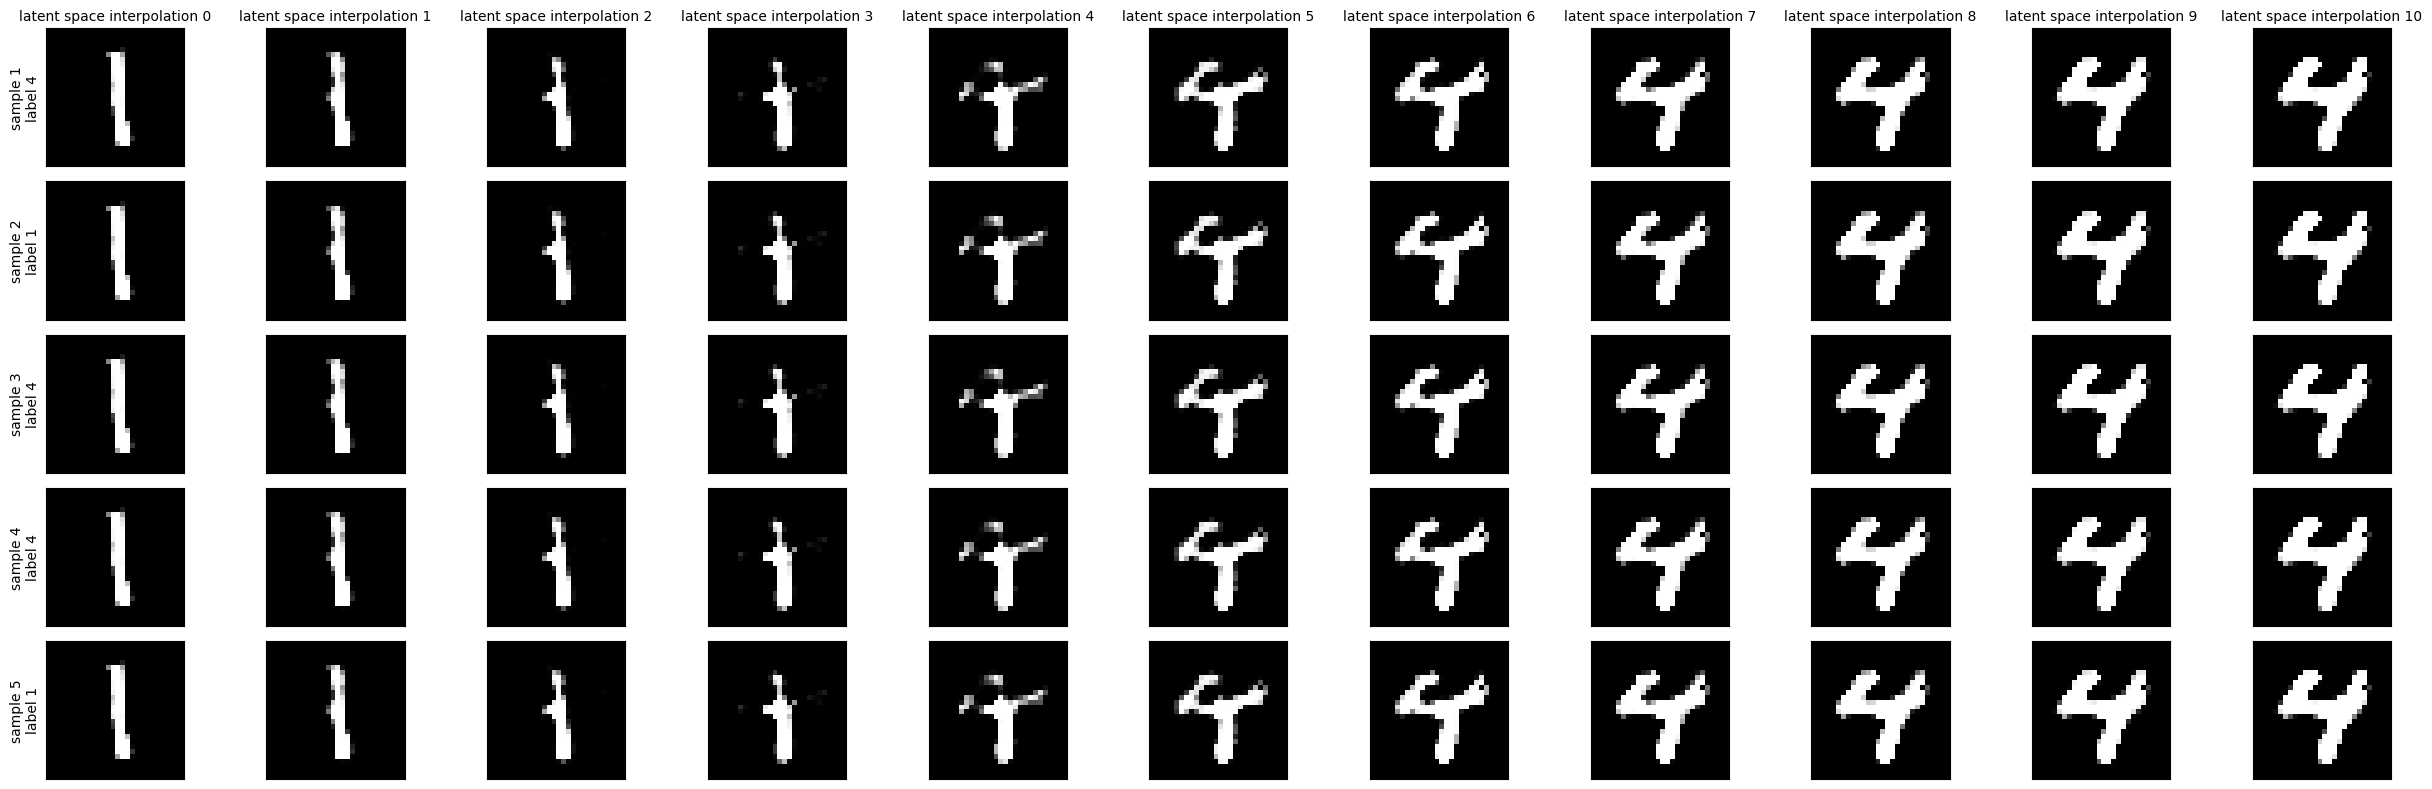

In [16]:
interpolated_images, labels = interpolate_in_latent_space(model32, trainloader, n=11)

fig, axs = plt.subplots(5, 11, figsize=(25, 8))
for i in range(5):
    for j in range(11):
        axs[i][j].imshow(interpolated_images[j][0], cmap='gray')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if j == 0:
            axs[i][j].set_ylabel(f"sample {i+1}\nlabel {labels[i%3]}", fontsize=10)
        if i == 0:
            axs[i][j].set_title(f"latent space interpolation {j}", fontsize=10)
plt.tight_layout()
plt.show()

Variational Autoencoder (VAE):

In [17]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

defining VAE

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )
        self.mu = nn.Linear(32, 16)
        self.log_var = nn.Linear(32, 16)
        self.decoder = nn.Sequential(
            nn.Linear(16, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x.view(-1, 784))
        mu, log_var = self.mu(x), self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var


Defining loss

In [19]:
def vae_loss(x, x_reconstructed, mu, log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(x_reconstructed, x.view(-1, 784))
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence


Training VAE

In [20]:
vae = VAE()
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    for (data, _) in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_reconstructed, mu, log_var = vae(data)
        loss = vae_loss(data, x_reconstructed, mu, log_var)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} -- Loss: {loss.item():.4f}')


Epoch 1 -- Loss: 13611.5127
Epoch 2 -- Loss: 12868.5400
Epoch 3 -- Loss: 11452.8867
Epoch 4 -- Loss: 11323.7070
Epoch 5 -- Loss: 11343.3105
Epoch 6 -- Loss: 11088.9170
Epoch 7 -- Loss: 10908.2734
Epoch 8 -- Loss: 11415.0967
Epoch 9 -- Loss: 10889.5811
Epoch 10 -- Loss: 10862.6523
Epoch 11 -- Loss: 10865.5234
Epoch 12 -- Loss: 10835.5254
Epoch 13 -- Loss: 10803.2109
Epoch 14 -- Loss: 11225.9121
Epoch 15 -- Loss: 10586.3438
Epoch 16 -- Loss: 10946.7197
Epoch 17 -- Loss: 10524.9082
Epoch 18 -- Loss: 11032.5957
Epoch 19 -- Loss: 10659.7490
Epoch 20 -- Loss: 10908.4980


generating 64 images and display.

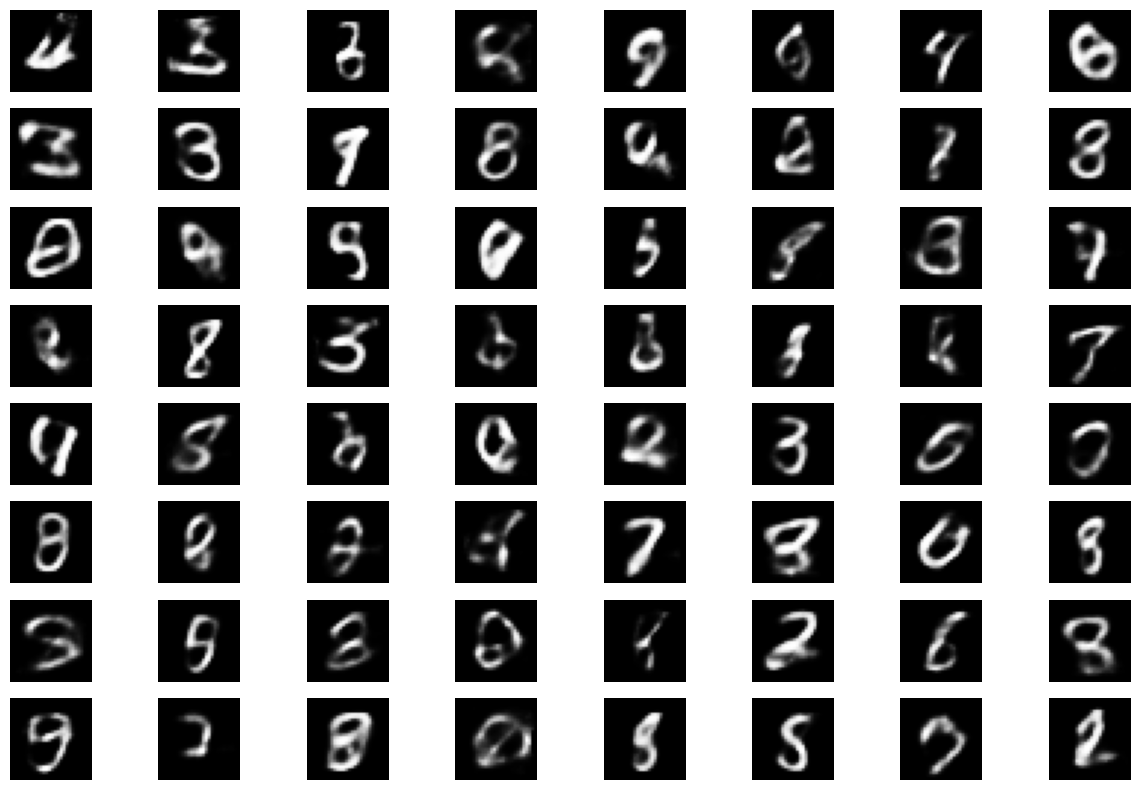

In [21]:
with torch.no_grad():
    z = torch.randn(64, 16)
    vae.to('cpu')
    generated_images = vae.decoder(z).view(-1, 1, 28, 28)

fig, axes = plt.subplots(8, 8, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(generated_images[i].numpy()), cmap='gray')
    ax.axis('off')
plt.show()

CNN


Downloading the CIFAR10 dataset and loading

In [22]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12503958.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Self attention

In [23]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        attention = self.softmax(torch.bmm(query, key))
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        return out

CNN with selfattention

In [24]:
class CNNWithSelfAttention(nn.Module):
    def __init__(self):
        super(CNNWithSelfAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.sa1 = SelfAttention(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.sa2 = SelfAttention(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.sa1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.sa2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNWithSelfAttention()


defining loss criterian

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training 

In [26]:
num_epochs = 10
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
      
    print(f'Epoch {epoch+1} loss: {running_loss / 500:.4f}')

Epoch 1 loss: 1.9666
Epoch 2 loss: 1.7039
Epoch 3 loss: 1.6275
Epoch 4 loss: 1.5714
Epoch 5 loss: 1.5250
Epoch 6 loss: 1.4648
Epoch 7 loss: 1.4215
Epoch 8 loss: 1.3713
Epoch 9 loss: 1.3309
Epoch 10 loss: 1.3018


Testing and telling the accuracy

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')


Accuracy of the network on the 10000 test images: 51.97%
